In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import os
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

####Downloading HTML file from https://en.tutiempo.net/climate/2013/ws-421820.html till https://en.tutiempo.net/climate/201\5/ws-421820.html

In [2]:
for year in range(2013,2016):
    for month in range(1,13):
        if month<10:
            url="https://en.tutiempo.net/climate/0{}-{}/ws-421820.html".format(month,year)
        else:
            url="https://en.tutiempo.net/climate/{}-{}/ws-421820.html".format(month,year)
        data=requests.request("GET",url)
        data_utf=data.text.encode('utf=8')
        if not os.path.exists("C:\\Users\karti\OneDrive\Desktop\Projects\Air Quality Index\data_from_web\{}".format(year)):
            os.makedirs("C:\\Users\karti\OneDrive\Desktop\Projects\Air Quality Index\data_from_web\{}".format(year))
        with open("C:\\Users\karti\OneDrive\Desktop\Projects\Air Quality Index\data_from_web\{}\{}.html".format(year,month),"wb") as html_file:
            html_file.write(data_utf)

### Getting AQI level at date level

In [3]:
def check_datatype(x): ##Removing Strings from PM2.5
    try:
        float(x)
        return  True
    except:
        return False

In [4]:
def check_date(x,year): ##Correcting date type 
    try:
        pd.to_datetime(x)
        return pd.to_datetime(x)
    except:
        if len(x.split(" "))==2:
            return pd.to_datetime(x.split(" ")[0])
        else:
            updated_date = x.split("/")[0]+"/"+x.split("/")[1]+"/"+str(year)
        return pd.to_datetime(updated_date)

In [5]:
def getting_aqi(year):
    df=pd.read_csv("C:\\Users\karti\OneDrive\Desktop\Projects\Air Quality Index\AQI\{}.csv".format(year))
    df["Date_updated"]=df.Date.apply(lambda x:check_date(x,year))
    df=df[df["PM2.5"].apply(lambda x: check_datatype(x))]
    df["PM2.5"]=df["PM2.5"].apply(lambda x: float(x))
    t=pd.DataFrame(df.groupby(["Date_updated"],as_index=False).agg({'PM2.5':'mean'}))
    return t

### Reading Table from downloaded HTML files using BeautifulSoup, and appending them with AQI data

In [6]:
concatenated_final_data=pd.DataFrame()
for year in range(2013,2016):
    for month in range(1,13):
        final_df=[]
        monthly_data=[]
        html_file=open("C:\\Users\karti\OneDrive\Desktop\Projects\Air Quality Index\data_from_web\{}\{}.html".format(year,month),"rb")
        html_file_to_text=html_file.read()
        soup=BeautifulSoup(html_file_to_text,"lxml")
        for table in soup.findAll('table',{'class':'medias mensuales numspan'}):
            for tbody in table:
                for tr in tbody:
                    data_from_html_file=tr.get_text()
                    monthly_data.append(data_from_html_file)
        num_rows=len(monthly_data)/15
        for times in range(round(num_rows)):
            interim_table=[]
            for num_cols in range(15):
                interim_table.append(monthly_data[0])
                monthly_data.pop(0)
            final_df.append(interim_table)
        final_df.pop(0)
        final_df.pop(-1)
        df=pd.DataFrame(final_df, columns=['Day', 'T', 'TM', 'Tm', 'SLP', 'H', 'PP', 'VV', 'V', 'VM', 'VG', 'RA', 'SN', 'TS', 'FG'])
        df['Day']=df.Day.apply(lambda x: pd.to_datetime(str(year)+"-"+str(month)+"-"+str(x)))
        df_aqi=getting_aqi(year)
        final_data=pd.merge(df,df_aqi,left_on='Day',right_on='Date_updated',how='left').drop(['Date_updated'],axis='columns')
        concatenated_final_data=pd.concat([concatenated_final_data,final_data],axis='rows')
                

# Reading the Data

In [7]:
df=concatenated_final_data[~concatenated_final_data['PM2.5'].isnull()]

# Cleaning the data and preparing the final cohort

In [8]:
df.Day.dt.year.unique()

array([2013, 2014, 2015], dtype=int64)

In [9]:
def check_float_value(x):
    try:
        float(x)
        return False
    except:
        return True
    

In [10]:
df

,Day,T,TM,Tm,SLP,H,PP,VV,V,VM,VG,RA,SN,TS,FG,PM2.5
0,2013-01-01,9.1,15.3,4,1015.6,90,0,0.5,0,-,-,,,,o,284.795833
1,2013-01-02,7.4,9.8,4.8,1017.6,93,0,0.5,4.3,9.4,-,,,,o,332.708333
2,2013-01-03,7.8,12.7,4.4,1018.5,87,0,0.6,4.4,11.1,-,,,,o,36.357143
3,2013-01-04,,,,,,,,,,,,,,o,46.416667
4,2013-01-05,,,,,,,,,,,,,,o,94.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,2015-12-27,16.3,22.5,7.6,1020.6,64,0,1.4,8.1,14.8,-,,,,,255.333333
27,2015-12-28,,,,,,,,,,,,,,,199.916667
28,2015-12-29,,,,,,,,,,,,,,,190.500000
29,2015-12-30,,,,,,,,,,,,,,o,217.727273


In [11]:
for i in df.columns:
    print("Columns {} has {} NULL Values".format(i,df[i].apply(lambda x: check_float_value(x)).sum()))

Columns Day has 1063 NULL Values
Columns T has 520 NULL Values
Columns TM has 520 NULL Values
Columns Tm has 520 NULL Values
Columns SLP has 520 NULL Values
Columns H has 520 NULL Values
Columns PP has 526 NULL Values
Columns VV has 520 NULL Values
Columns V has 520 NULL Values
Columns VM has 529 NULL Values
Columns VG has 1061 NULL Values
Columns RA has 1063 NULL Values
Columns SN has 1063 NULL Values
Columns TS has 1063 NULL Values
Columns FG has 1063 NULL Values
Columns PM2.5 has 0 NULL Values


In [12]:
def replace_non_numeric_to_null(x):
    try:
        float(x)
        return float(x)
    except:
        return np.nan

In [13]:
for i in df.columns:
    df[i]=df[i].apply(lambda x: replace_non_numeric_to_null(x))

C:\Users\karti\AppData\Local\Temp/ipykernel_11048/543670657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i]=df[i].apply(lambda x: replace_non_numeric_to_null(x))


In [14]:
#Dropping Columns where all values are null
df_1=df.dropna(axis='columns',how='all')

In [15]:
#Dropping Columns where 60% of values are null
df_2=df_1.dropna(thresh=df.shape[0]*0.4,how='all',axis='columns')
df_2.shape

(1063, 10)

In [16]:
for i in np.arange(0,1.1,0.1):
    print(df_2.dropna(thresh=df_2.shape[1]*i,how='all',axis='rows').shape)
    

(1063, 10)
(1063, 10)
(543, 10)
(543, 10)
(543, 10)
(543, 10)
(543, 10)
(543, 10)
(543, 10)
(543, 10)
(528, 10)


In [17]:
##We can safely remove all null values, hence it's appropriate to use thresh=df.shape[1]
df_4=df_2.dropna(thresh=df_2.shape[1]*1,how='all',axis='rows')
df_4.shape

(528, 10)

In [18]:
df_4.drop_duplicates().shape

(528, 10)

In [19]:
for i in df_4.columns:
    print("{}: {} unique values".format(i,df[i].nunique()))


T: 218 unique values
TM: 217 unique values
Tm: 206 unique values
SLP: 236 unique values
H: 72 unique values
PP: 32 unique values
VV: 20 unique values
V: 93 unique values
VM: 25 unique values
PM2.5: 977 unique values


In [20]:
df_4.describe()

,T,TM,Tm,SLP,H,PP,VV,V,VM,PM2.5
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000
mean,25.051326,31.935227,19.042045,1008.328977,65.429924,1.885170,1.774811,6.443939,15.506250,112.515023
std,7.332802,7.009003,7.505991,7.579027,14.936768,8.543372,0.600782,4.054033,7.847726,84.451779
min,6.700000,9.800000,0.000000,991.500000,21.000000,0.000000,0.300000,0.400000,1.900000,2.095238
25%,18.400000,27.100000,11.975000,1001.500000,56.000000,0.000000,1.400000,3.300000,11.100000,44.791667
50%,27.300000,33.850000,20.550000,1009.050000,67.000000,0.000000,1.900000,5.900000,14.800000,85.847222
75%,31.000000,36.700000,25.700000,1015.000000,76.000000,0.000000,1.900000,8.900000,18.300000,156.281250
max,38.500000,45.500000,32.700000,1022.300000,98.000000,122.940000,3.400000,24.400000,57.600000,536.500000


# Applying Machine Learning Model

### Linear Regression

#### Making X and y variables 

In [21]:
df_4.index=np.arange(0,df_4.shape[0],1)

In [22]:
X=df_4.iloc[:,:-1] #independent variables
y=df_4.iloc[:,-1] # dependent variables 

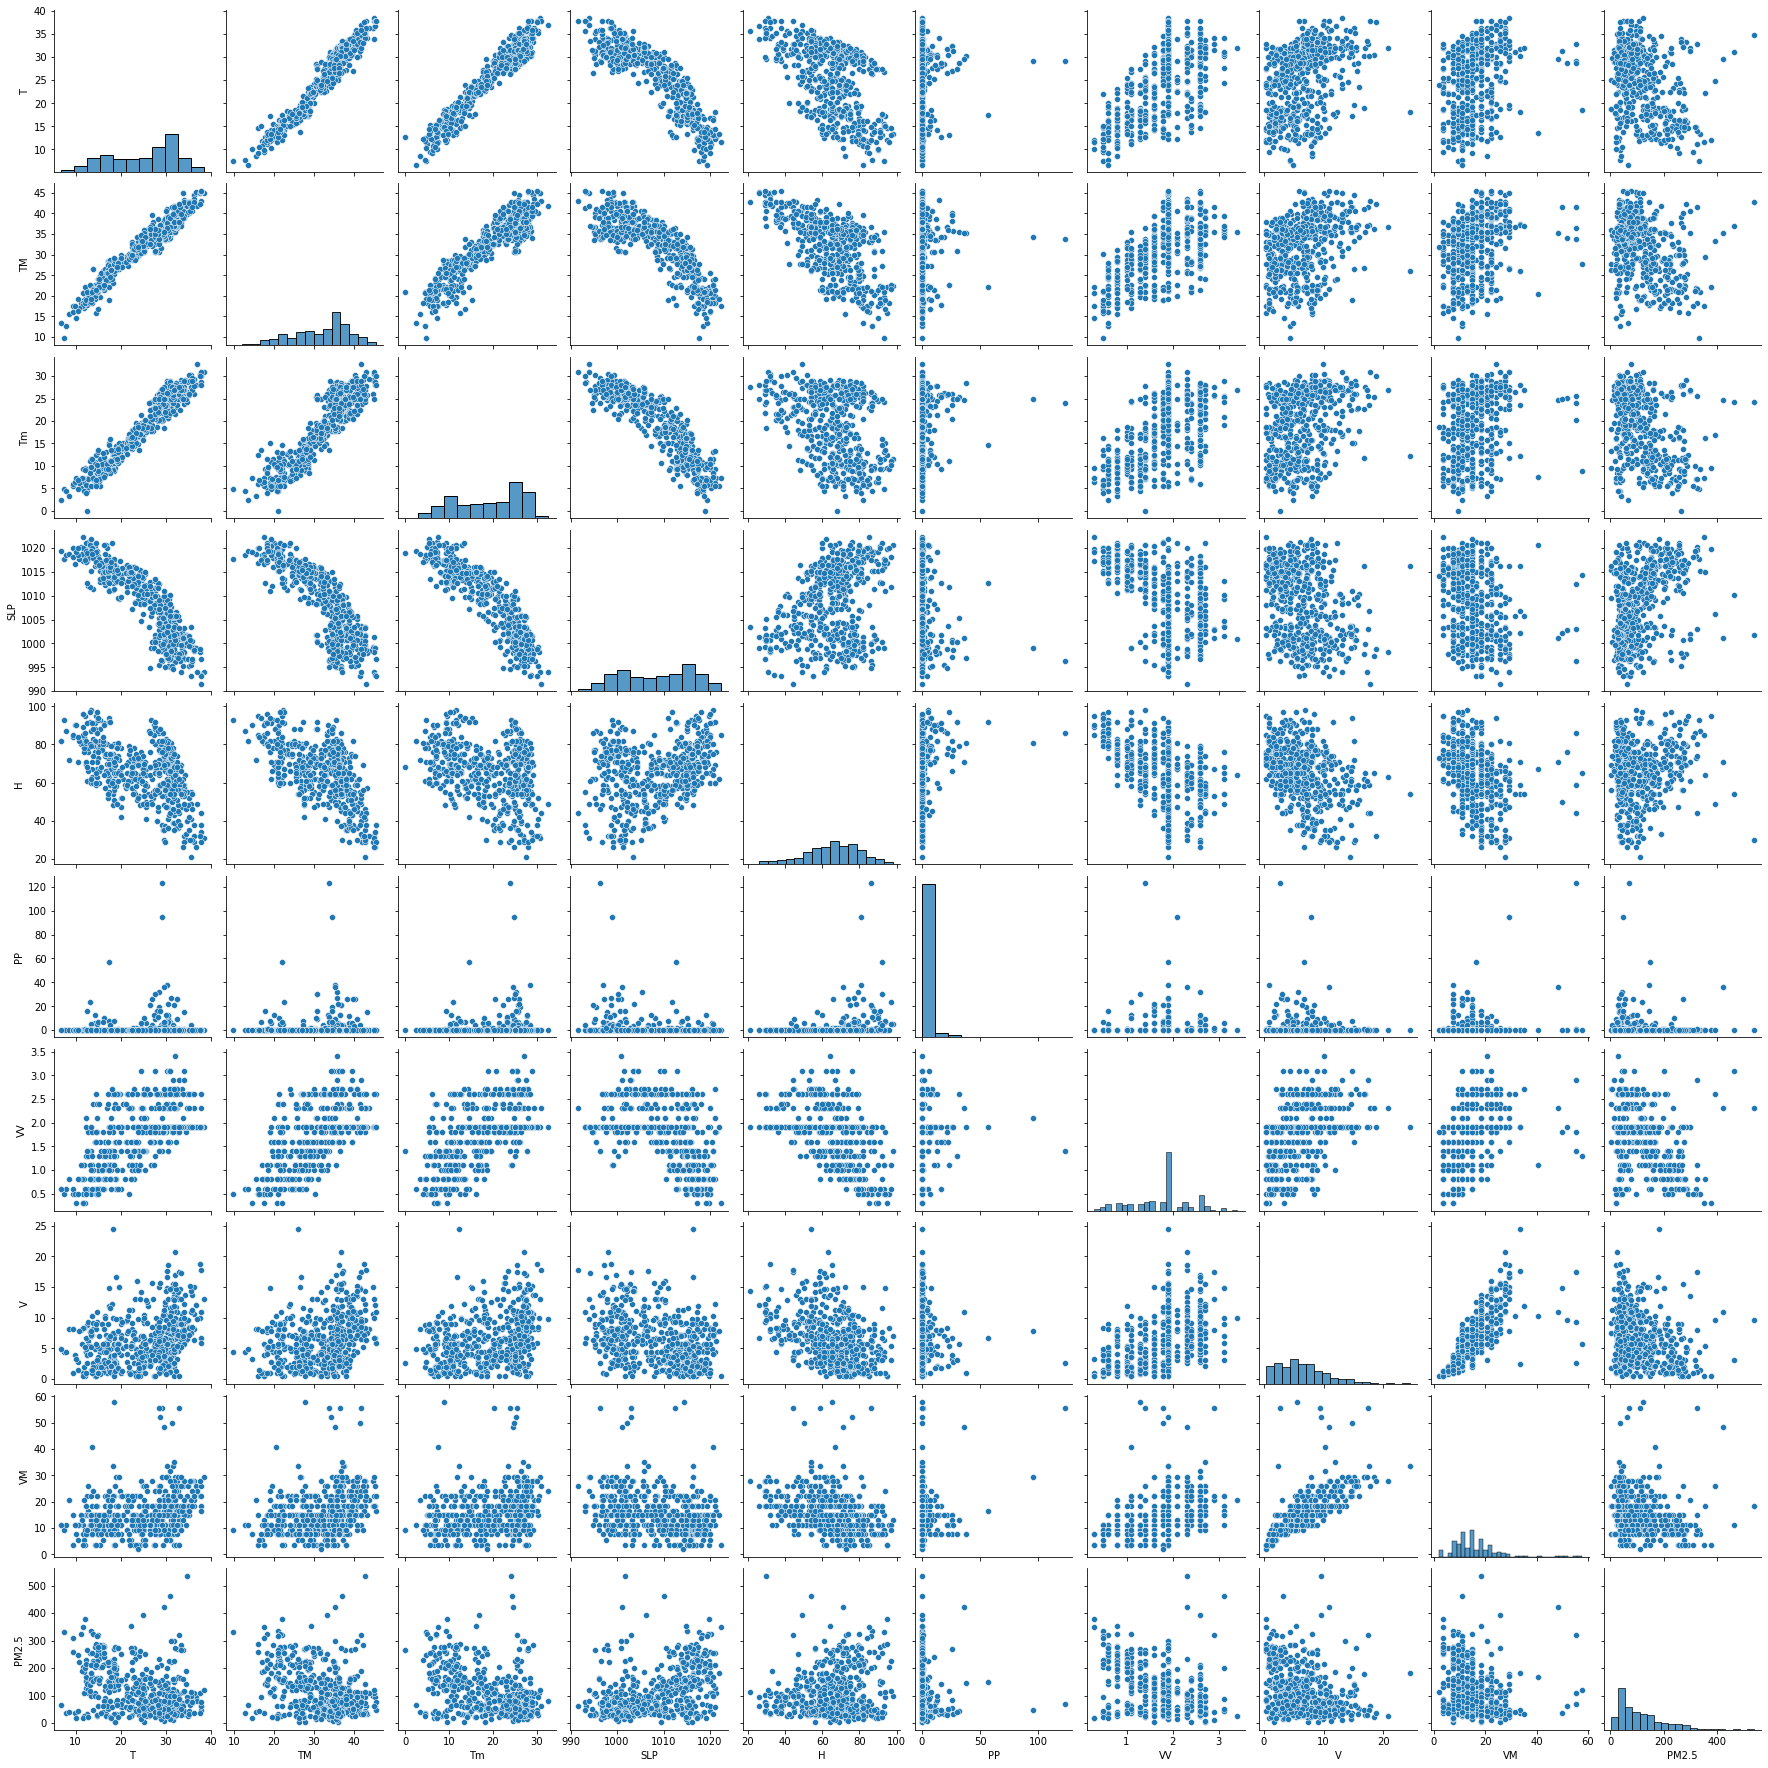

In [23]:
sns.pairplot(df_4)

In [24]:
df_4.corr()

,T,TM,Tm,SLP,H,PP,VV,V,VM,PM2.5
T,1.000000,0.967935,0.966069,-0.890510,-0.525005,0.060057,0.607340,0.338279,0.273197,-0.397005
TM,0.967935,1.000000,0.902838,-0.837513,-0.611791,0.031496,0.603707,0.329572,0.281036,-0.367055
Tm,0.966069,0.902838,1.000000,-0.901850,-0.346007,0.101061,0.553152,0.322543,0.246474,-0.422157
SLP,-0.890510,-0.837513,-0.901850,1.000000,0.311487,-0.180801,-0.473416,-0.353878,-0.279327,0.389427
H,-0.525005,-0.611791,-0.346007,0.311487,1.000000,0.221617,-0.486086,-0.406313,-0.358208,0.125524
PP,0.060057,0.031496,0.101061,-0.180801,0.221617,1.000000,0.014620,-0.052061,0.158305,-0.059591
VV,0.607340,0.603707,0.553152,-0.473416,-0.486086,0.014620,1.000000,0.434624,0.361721,-0.412002
V,0.338279,0.329572,0.322543,-0.353878,-0.406313,-0.052061,0.434624,1.000000,0.743176,-0.230468
VM,0.273197,0.281036,0.246474,-0.279327,-0.358208,0.158305,0.361721,0.743176,1.000000,-0.201579
PM2.5,-0.397005,-0.367055,-0.422157,0.389427,0.125524,-0.059591,-0.412002,-0.230468,-0.201579,1.000000


C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PM2.5', ylabel='Density'>

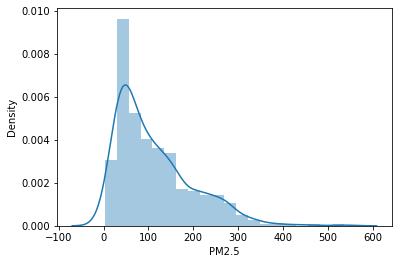

In [25]:
sns.distplot(y)

# Checking Feature Importance using ExtraTreeRegressor

In [26]:
from sklearn.ensemble import ExtraTreesRegressor
model=ExtraTreesRegressor()
model.fit(X,y)

ExtraTreesRegressor()

In [27]:
model.feature_importances_

array([0.11767   , 0.10720499, 0.14464716, 0.11099111, 0.08203426,
       0.03399502, 0.20070298, 0.09063708, 0.1121174 ])

In [28]:
##Since we only have 10 columns, and ~500 rows, we won't be dropping any columns

# Train, test and Split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)

# Feature Scaling

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
mms = MinMaxScaler()

In [33]:
X_train_scaled = mms.fit_transform(X_train)

In [34]:
X_train=pd.DataFrame(X_train_scaled,columns=X_train.columns)

In [35]:
X_test_scaled = mms.transform(X_test)

In [36]:
X_test=pd.DataFrame(X_test_scaled,columns=X_test.columns)

In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
lr=LinearRegression(normalize=True)

In [39]:
lr.fit(X_train,y_train)

LinearRegression(normalize=True)

In [40]:
print("R square Value on train set: {}".format(lr.score(X_train,y_train)))

R square Value on train set: 0.2162889027202307


In [41]:
print("R square Value on test set: {}".format(lr.score(X_test,y_test)))

R square Value on test set: 0.35068499509041884


In [42]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(lr,X,y,cv=5)

In [43]:
score.mean()

0.15513654490071077

## Linear Regression - Model Evaluation

In [44]:
pd.DataFrame(lr.coef_,X_train.columns,columns=['Coefficient_by_linear_Regression'])

,Coefficient_by_linear_Regression
T,250.350968
TM,-58.959975
Tm,-230.920727
SLP,50.790288
H,-21.439118
PP,28.828619
VV,-138.413987
V,6.822318
VM,-28.123564


In [45]:
prediction=lr.predict(X_test)

C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PM2.5', ylabel='Density'>

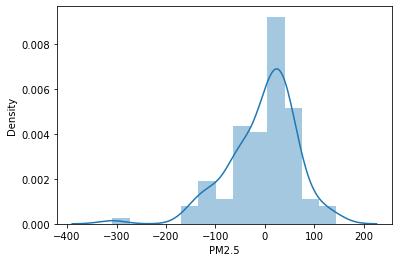

In [46]:
sns.distplot(prediction-y_test)

In [47]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,prediction))
print('MSE:', metrics.mean_squared_error(y_test,prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,prediction)))

MAE: 51.32590234805954
MSE: 4692.174136722759
RMSE: 68.49944625121256


In [48]:
##Saving Linear Regression Pickle File
import pickle
file=open("regression_model.pkl","wb")
pickle.dump(lr,file)

# Decision Tree Regressor

In [49]:
from sklearn.tree import DecisionTreeRegressor

In [50]:
dtree_model=DecisionTreeRegressor(criterion='mse')

In [51]:
dtree_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [52]:
print("R square Value on train set: {}".format(dtree_model.score(X_train,y_train)))

R square Value on train set: 1.0


In [53]:
print("R square Value on test set: {}".format(dtree_model.score(X_test,y_test)))

R square Value on test set: -0.09959458483682226


In [54]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(dtree_model,X,y,cv=5)

In [55]:
score
#A horizontal line would give a better preidction than this model, and since the model is already overfit. We will be using GridSearchCV
#to make the model fit properly

array([-2.20254372,  0.01517526, -0.35806667, -1.51013549, -0.1195562 ])

In [56]:
prediction_tree=dtree_model.predict(X_test)

In [57]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,prediction_tree))
print('MSE:', metrics.mean_squared_error(y_test,prediction_tree))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,prediction_tree)))

MAE: 64.02505449528279
MSE: 7946.049656699692
RMSE: 89.14061732285508


C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PM2.5', ylabel='Density'>

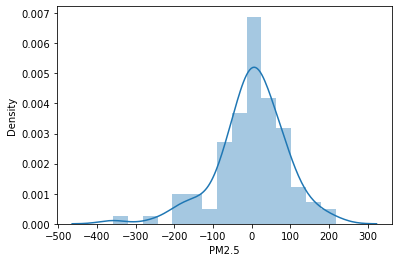

In [58]:
sns.distplot(prediction_tree-y_test)

# Hyperparameter tuning in DecisionTreeRegressor

In [59]:
DecisionTreeRegressor()


DecisionTreeRegressor()

In [60]:
params={ "criterion" : ["mse"],
    "splitter" : ["best"],
    "max_depth": [None,1,5,10], # Putting 1,5,10 after doing some trials on the data
    "min_samples_split": list(range(10)),
    "min_samples_leaf": list(range(10)),
    "max_features":["auto", "sqrt", "log2"],
    "random_state":[42]
}

In [61]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [62]:
random_search=GridSearchCV(dtree_model, param_grid=params,n_jobs=-1,cv=10)

In [63]:
import time
start=time.time()
random_search.fit(X_train,y_train)
end=time.time()
print("minutes: {}".format((end-start)/60))

minutes: 0.16760628223419188


C:\Users\karti\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.01801895 -0.01801895
 -0.01801895]
  warnings.warn(


In [64]:
random_search.best_params_

{'criterion': 'mse',
 'max_depth': 1,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 42,
 'splitter': 'best'}

In [65]:
prediction_decisiontree=random_search.predict(X_test)

In [66]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,prediction_decisiontree))
print('MSE:', metrics.mean_squared_error(y_test,prediction_decisiontree))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,prediction_decisiontree)))

MAE: 58.18663415068879
MSE: 5512.613245569303
RMSE: 74.24697465600401


In [67]:
random_search.score(X_train,y_train)

0.17713784004910604

# Random Forest Regressor

In [68]:
from sklearn.ensemble import RandomForestRegressor

In [69]:
rfr_model=RandomForestRegressor()

In [70]:
rfr_model.fit(X_train,y_train)

RandomForestRegressor()

In [71]:
print("R square Value on train set: {}".format(rfr_model.score(X_train,y_train)))

R square Value on train set: 0.8838303662249957


In [72]:
print("R square Value on test set: {}".format(rfr_model.score(X_test,y_test)))

R square Value on test set: 0.27572721279124657


In [73]:
predictions=rfr_model.predict(X_test)

In [74]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,predictions))
print('MSE:', metrics.mean_squared_error(y_test,predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,predictions)))

MAE: 54.43884088817144
MSE: 5233.84492022675
RMSE: 72.34531719625501


# Hyperparameter tuning in Random Forest Regressor

In [75]:
RandomForestRegressor()

RandomForestRegressor()

In [76]:
params={ "criterion" : ["mse"],
        "n_estimators":[50,100,150,200],
    "max_depth": [None,1,2,3],
    "min_samples_split": [1,2,3,4,5],
    "min_samples_leaf": [1,2,3,4],
    "max_features":["auto"],
    "random_state":[42]
}

In [77]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [78]:
random_search_random_forest=GridSearchCV(rfr_model, param_grid=params,n_jobs=-1,cv=10)

In [79]:
import time
start=time.time()
random_search_random_forest.fit(X_train,y_train)
end=time.time()
print(end-start)

102.3827874660492


C:\Users\karti\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.14634649 0.14932577
 0.14168045 0.14581509 0.13398138 0.15115205 0.14149147 0.14546466
 0.13582597 0.14892052 0.14497056 0.15079453 0.14740934 0.15751702
 0.14834296 0.15155124        nan        nan        nan        nan
 0.15262537 0.16022551 0.159442   0.16373574 0.15262537 0.16022551
 0.159442   0.16373574 0.15262537 0.16022551 0.159442   0.16373574
 0.15736686 0.16334213 0.16304891 0.16684965        nan        nan
        nan        nan 0.15649193 0.16653188 0.16705566 0.17056599
 0.15649193 0.16653188 0.16705566 0.17056599 0.15649193 0.16653188
 0.16705566 0.17056599 0.15649193 0.16653188 0.16705566 0.17056599
        nan        nan        nan        nan 0.15685353 0.16148557
 0.16737289 0.16757332 0.15685353 0.16148557 0.16737289 0.16757332
 0.15685353 0.16148557 0.16737289 0.16757332 0.156853

In [80]:
print("R square Value on train set: {}".format(random_search_random_forest.score(X_train,y_train)))

print("R square Value on test set: {}".format(random_search_random_forest.score(X_test,y_test)))

R square Value on train set: 0.21621972858358018
R square Value on test set: 0.26871954348783633


In [81]:
predictions_rf=random_search_random_forest.predict(X_test)

In [82]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,predictions_rf))
print('MSE:', metrics.mean_squared_error(y_test,predictions_rf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,predictions_rf)))

MAE: 57.24258022148476
MSE: 5284.48475515363
RMSE: 72.69446165392264


In [83]:
random_search_random_forest.best_params_

{'criterion': 'mse',
 'max_depth': 1,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200,
 'random_state': 42}

In [84]:
##Saving Linear Regression Pickle File
import pickle
file=open("random_search_random_forest.pkl","wb")
pickle.dump(random_search_random_forest,file)

# XGBoost Regressor

In [85]:
import xgboost as xgb

In [86]:
xgb_regressor=xgb.XGBRegressor()
xgb_regressor.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [87]:
print("R square Value on train set: {}".format(xgb_regressor.score(X_train,y_train)))

R square Value on train set: 0.9998950819438818


In [88]:
print("R square Value on test set: {}".format(xgb_regressor.score(X_test,y_test)))

R square Value on test set: 0.2907007064917393


In [89]:
predictions_xgb=xgb_regressor.predict(X_test)

In [90]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,predictions_xgb))
print('MSE:', metrics.mean_squared_error(y_test,predictions_xgb))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,predictions_xgb)))

MAE: 52.356571750922484
MSE: 5125.641291253757
RMSE: 71.59358414867744


In [91]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(xgb_regressor,X,y,cv=5)

In [92]:
score

array([-0.25417396,  0.23545504, -0.27967557, -0.40116434,  0.14064921])

# Hyperparameter Tuning - XGBoost

In [93]:
xgb.XGBRegressor()

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)

In [94]:
from sklearn.model_selection import RandomizedSearchCV

In [95]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Various learning rate parameters
learning_rate = ['0.05','0.1', '0.2','0.3','0.5','0.6']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
#Subssample parameter values
subsample=[0.7,0.6,0.8]
# Minimum child weight parameters
min_child_weight=[3,4,5,6,7]

In [96]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'learning_rate': ['0.05', '0.1', '0.2', '0.3', '0.5', '0.6'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_weight': [3, 4, 5, 6, 7]}


In [97]:
regressor=xgb.XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
xg_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 1)
xg_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END learning_rate=0.3, max_depth=10, min_child_weight=6, n_estimators=1100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=10, min_child_weight=6, n_estimators=1100, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=10, min_child_weight=6, n_estimators=1100, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, min_child_weight=6, n_estimators=1100, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=10, min_child_weight=6, n_estimators=1100, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=20, min_child_weight=6, n_estimators=600, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=20, min_child_weight=6, n_estimators=600, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=20, min_child_weight=6, n_estimators=600, subsample=0.7; total time=   0.4s
[CV] END learning_ra

[CV] END learning_rate=0.5, max_depth=30, min_child_weight=7, n_estimators=1100, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=7, n_estimators=1100, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=7, n_estimators=1100, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=25, min_child_weight=5, n_estimators=800, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=25, min_child_weight=5, n_estimators=800, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=25, min_child_weight=5, n_estimators=800, subsample=0.6; total time=   0.5s
[CV] END learning_rate=0.3, max_depth=25, min_child_weight=5, n_estimators=800, subsample=0.6; total time=   0.4s
[CV] END learning_rate=0.3, max_depth=25, min_child_weight=5, n_estimators=800, subsample=0.6; total time=   0.5s
[CV] END learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=600, subsa

[CV] END learning_rate=0.1, max_depth=5, min_child_weight=4, n_estimators=1200, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=6, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=6, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=6, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=6, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=6, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.6, max_depth=25, min_child_weight=7, n_estimators=800, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.6, max_depth=25, min_child_weight=7, n_estimators=800, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.6, max_depth=25, min_child_weight=7, n_estimators=800, subsampl

[CV] END learning_rate=0.05, max_depth=30, min_child_weight=3, n_estimators=1100, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=30, min_child_weight=3, n_estimators=1100, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.05, max_depth=30, min_child_weight=3, n_estimators=1100, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.05, max_depth=30, min_child_weight=3, n_estimators=1100, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.2, max_depth=30, min_child_weight=5, n_estimators=1200, subsample=0.6; total time=   0.7s
[CV] END learning_rate=0.2, max_depth=30, min_child_weight=5, n_estimators=1200, subsample=0.6; total time=   0.8s
[CV] END learning_rate=0.2, max_depth=30, min_child_weight=5, n_estimators=1200, subsample=0.6; total time=   0.7s
[CV] END learning_rate=0.2, max_depth=30, min_child_weight=5, n_estimators=1200, subsample=0.6; total time=   0.7s
[CV] END learning_rate=0.2, max_depth=30, min_child_weight=5, n_estimators=1

[CV] END learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=800, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=800, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.05, max_depth=15, min_child_weight=6, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=15, min_child_weight=6, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=15, min_child_weight=6, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=15, min_child_weight=6, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.05, max_depth=15, min_child_weight=6, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.3, max_depth=20, min_child_weight=5, n_estimators=300, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=20, min_child_weight=5, n_estimators=300, sub

[CV] END learning_rate=0.5, max_depth=25, min_child_weight=3, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=25, min_child_weight=3, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=25, min_child_weight=3, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=25, min_child_weight=3, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=25, min_child_weight=3, n_estimators=400, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=3, n_estimators=900, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=3, n_estimators=900, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=3, n_estimators=900, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=30, min_child_weight=3, n_estimators=900, subsampl

[CV] END learning_rate=0.3, max_depth=5, min_child_weight=4, n_estimators=100, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=3, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=3, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=3, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=3, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=20, min_child_weight=3, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=5, min_child_weight=6, n_estimators=900, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=5, min_child_weight=6, n_estimators=900, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=5, min_child_weight=6, n_estimators=900, subsample=0.

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          predictor=None, random_state=None,
                             

In [98]:
print("R square Value on train set: {}".format(xg_random.score(X_train,y_train)))

print("R square Value on test set: {}".format(xg_random.score(X_test,y_test)))

R square Value on train set: -1068.7444788111
R square Value on test set: -5121.3392663830255


In [99]:
predictions_xgb=xg_random.predict(X_test)

In [100]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,predictions_xgb))
print('MSE:', metrics.mean_squared_error(y_test,predictions_xgb))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,predictions_xgb)))

MAE: 53.36042490493467
MSE: 5121.3392663830255
RMSE: 71.56353307644213


In [101]:
##Saving Linear Regression Pickle File
import pickle
file=open("xgboost_random.pkl","wb")
pickle.dump(xg_random,file)

# Artificial Neural Network

In [102]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout

In [103]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

# Fitting the ANN to the Training set
model_history=NN_model.fit(X_train, y_train,validation_split=0.33, batch_size = 10,epochs=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================]

29/29 [==============================] - 0s 2ms/step - loss: 46.4437 - mean_absolute_error: 46.4437 - val_loss: 50.2307 - val_mean_absolute_error: 50.2307
Epoch 44/100
29/29 [==============================] - 0s 2ms/step - loss: 47.6447 - mean_absolute_error: 47.6447 - val_loss: 54.2823 - val_mean_absolute_error: 54.2823
Epoch 45/100
29/29 [==============================] - 0s 2ms/step - loss: 47.8649 - mean_absolute_error: 47.8649 - val_loss: 48.1763 - val_mean_absolute_error: 48.1763
Epoch 46/100
29/29 [==============================] - 0s 2ms/step - loss: 46.3409 - mean_absolute_error: 46.3409 - val_loss: 48.3284 - val_mean_absolute_error: 48.3284
Epoch 47/100
29/29 [==============================] - 0s 2ms/step - loss: 46.2334 - mean_absolute_error: 46.2334 - val_loss: 46.3636 - val_mean_absolute_error: 46.3636
Epoch 48/100
29/29 [==============================] - 0s 2ms/step - loss: 46.3907 - mean_absolute_error: 46.3907 - val_loss: 46.2300 - val_mean_absolute_error: 46.2300
Epoch

Epoch 92/100
29/29 [==============================] - 0s 2ms/step - loss: 44.1207 - mean_absolute_error: 44.1207 - val_loss: 49.9624 - val_mean_absolute_error: 49.9624
Epoch 93/100
29/29 [==============================] - 0s 2ms/step - loss: 44.2537 - mean_absolute_error: 44.2537 - val_loss: 48.3995 - val_mean_absolute_error: 48.3995
Epoch 94/100
29/29 [==============================] - 0s 3ms/step - loss: 44.0387 - mean_absolute_error: 44.0387 - val_loss: 47.3273 - val_mean_absolute_error: 47.3273
Epoch 95/100
29/29 [==============================] - 0s 2ms/step - loss: 44.7255 - mean_absolute_error: 44.7255 - val_loss: 47.4243 - val_mean_absolute_error: 47.4243
Epoch 96/100
29/29 [==============================] - 0s 2ms/step - loss: 44.9880 - mean_absolute_error: 44.9880 - val_loss: 47.7486 - val_mean_absolute_error: 47.7486
Epoch 97/100
29/29 [==============================] - 0s 2ms/step - loss: 43.8020 - mean_absolute_error: 43.8020 - val_loss: 48.0759 - val_mean_absolute_error: 

# Model Evaluation

In [104]:
prediction=NN_model.predict(X_test)

4/4 [==============================] - 0s 1ms/step


C:\Users\karti\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

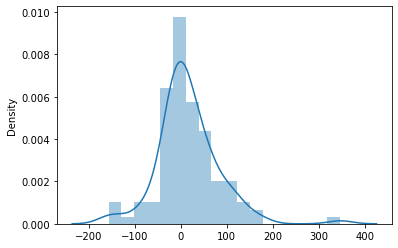

In [105]:
sns.distplot(y_test.values.reshape(-1,1)-prediction)

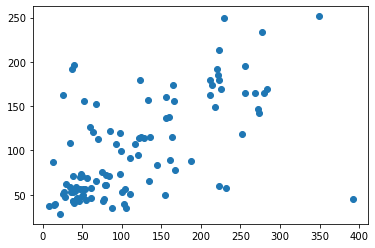

In [106]:
plt.scatter(y_test,prediction)

In [107]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 45.98704023388833
MSE: 4704.118483437938
RMSE: 68.58657655429332


In [108]:
##Saving ANN Pickle File
import pickle
file=open("ANN_Model.pkl","wb")
pickle.dump(NN_model,file)

INFO:tensorflow:Assets written to: ram://c1d24deb-aea2-47c5-8e1b-582726512eb5/assets
